<a href="https://colab.research.google.com/github/nouralhoudafouad/22007681_nouralhoudafouad/blob/main/Fraudent_Transaction_Detection_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
ealaxi_paysim1_path = kagglehub.dataset_download('ealaxi/paysim1')

print('Data source import complete.')


Using Colab cache for faster access to the 'paysim1' dataset.
Data source import complete.


In [19]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import scipy
from sklearn.metrics import classification_report, accuracy_score

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/paysim1/PS_20174392719_1491204439457_log.csv
/kaggle/input/creditcardfraud/creditcard.csv


In [20]:
from sklearn.ensemble import IsolationForest

In [21]:
import os
df = pd.read_csv(os.path.join(ealaxi_paysim1_path, 'PS_20174392719_1491204439457_log.csv'))

In [22]:
df = df.rename(columns={'oldbalanceOrg':'oldBalanceOrig', 'newbalanceOrig':'newBalanceOrig', \
                        'oldbalanceDest':'oldBalanceDest', 'newbalanceDest':'newBalanceDest'})
print(df.head())

   step      type    amount     nameOrig  oldBalanceOrig  newBalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815        170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295         21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145           181.0            0.00   
3     1  CASH_OUT    181.00   C840083671           181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720         41554.0        29885.86   

      nameDest  oldBalanceDest  newBalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0        0               0  
1  M2044282225             0.0             0.0        0               0  
2   C553264065             0.0             0.0        1               0  
3    C38997010         21182.0             0.0        1               0  
4  M1230701703             0.0             0.0        0               0  


In [23]:
df.dtypes

,0
step,int64
type,object
amount,float64
nameOrig,object
oldBalanceOrig,float64
newBalanceOrig,float64
nameDest,object
oldBalanceDest,float64
newBalanceDest,float64
isFraud,int64


In [24]:
df.shape

(6362620, 11)

In [25]:
df.isnull().sum()

,0
step,0
type,0
amount,0
nameOrig,0
oldBalanceOrig,0
newBalanceOrig,0
nameDest,0
oldBalanceDest,0
newBalanceDest,0
isFraud,0


In [26]:
df.isnull().values.any()

np.False_

In [27]:
print('\n The types of fraudulent transactions are {}'.format(\
list(df.loc[df.isFraud == 1].type.drop_duplicates().values))) # only 'CASH_OUT'
                                                             # & 'TRANSFER'

dft = df.loc[(df.isFraud == 1) & (df.type == 'TRANSFER')]
dfc = df.loc[(df.isFraud == 1) & (df.type == 'CASH_OUT')]

print ('\n The number of fraudulent TRANSFERs = {}'.\
       format(len(dft))) # 4097

print ('\n The number of fraudulent CASH_OUTs = {}'.\
       format(len(dfc))) # 4116


 The types of fraudulent transactions are ['TRANSFER', 'CASH_OUT']

 The number of fraudulent TRANSFERs = 4097

 The number of fraudulent CASH_OUTs = 4116


In [28]:
print('\nThe type of transactions in which isFlaggedFraud is set: \
{}'.format(list(df.loc[df.isFlaggedFraud == 1].type.drop_duplicates())))
                                                            # only 'TRANSFER'

dfTransfer = df.loc[df.type == 'TRANSFER']
dfFlagged = df.loc[df.isFlaggedFraud == 1]
dfNotFlagged = df.loc[df.isFlaggedFraud == 0]

print('\nMin amount transacted when isFlaggedFraud is set= {}'\
                                  .format(dfFlagged.amount.min())) # 353874.22

print('\nMax amount transacted in a TRANSFER where isFlaggedFraud is not set=\
 {}'.format(dfTransfer.loc[dfTransfer.isFlaggedFraud == 0].amount.max())) # 92445516.64


The type of transactions in which isFlaggedFraud is set: ['TRANSFER']

Min amount transacted when isFlaggedFraud is set= 353874.22

Max amount transacted in a TRANSFER where isFlaggedFraud is not set= 92445516.64


In [29]:
print('\nAre there any merchants among originator accounts for CASH_IN \
transactions? {}'.format(\
(df.loc[df.type == 'CASH_IN'].nameOrig.str.contains('M')).any())) # False


Are there any merchants among originator accounts for CASH_IN transactions? False


In [30]:
print('\nAre there any merchants among destination accounts for CASH_OUT \
transactions? {}'.format(\
(df.loc[df.type == 'CASH_OUT'].nameDest.str.contains('M')).any())) # False


Are there any merchants among destination accounts for CASH_OUT transactions? False


In [31]:
print('\nAre there merchants among any originator accounts? {}'.format(\
      df.nameOrig.str.contains('M').any())) # False

print('\nAre there any transactions having merchants among destination accounts\
 other than the PAYMENT type? {}'.format(\
(df.loc[df.nameDest.str.contains('M')].type != 'PAYMENT').any())) # False


Are there merchants among any originator accounts? False

Are there any transactions having merchants among destination accounts other than the PAYMENT type? False


In [32]:
print('\nWithin fraudulent transactions, are there destinations for TRANSFERS \
that are also originators for CASH_OUTs? {}'.format(\
(dft.nameDest.isin(dfc.nameOrig)).any())) # False
dfNotFraud = df.loc[df.isFraud == 0]


Within fraudulent transactions, are there destinations for TRANSFERS that are also originators for CASH_OUTs? False


In [33]:
print('\nFraudulent TRANSFERs whose destination accounts are originators of \
genuine CASH_OUTs: \n\n{}'.format(dft.loc[dft.nameDest.\
isin(dfNotFraud.loc[dfNotFraud.type == 'CASH_OUT'].nameOrig.drop_duplicates())]))


Fraudulent TRANSFERs whose destination accounts are originators of genuine CASH_OUTs: 

         step      type      amount     nameOrig  oldBalanceOrig  \
1030443    65  TRANSFER  1282971.57  C1175896731      1282971.57   
6039814   486  TRANSFER   214793.32  C2140495649       214793.32   
6362556   738  TRANSFER   814689.88  C2029041842       814689.88   

         newBalanceOrig     nameDest  oldBalanceDest  newBalanceDest  isFraud  \
1030443             0.0  C1714931087             0.0             0.0        1   
6039814             0.0   C423543548             0.0             0.0        1   
6362556             0.0  C1023330867             0.0             0.0        1   

         isFlaggedFraud  
1030443               0  
6039814               0  
6362556               0  


In [34]:
print('\nFraudulent TRANSFER to C423543548 occured at step = 486 whereas \
genuine CASH_OUT from this account occured earlier at step = {}'.format(\
dfNotFraud.loc[(dfNotFraud.type == 'CASH_OUT') & (dfNotFraud.nameOrig == \
                           'C423543548')].step.values)) # 185


Fraudulent TRANSFER to C423543548 occured at step = 486 whereas genuine CASH_OUT from this account occured earlier at step = [185]


/tmp/ipython-input-4005251038.py:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  fraud_check = pd.value_counts(df['isFraud'], sort =True)


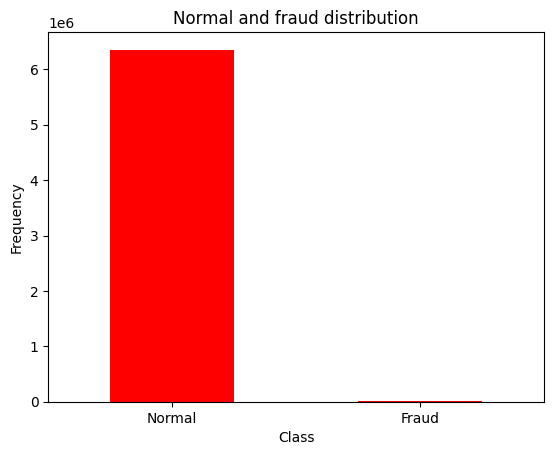

In [35]:
fraud_check = pd.value_counts(df['isFraud'], sort =True)
fraud_check.plot(kind = 'bar', rot=0, color='r')
plt.title("Normal and fraud distribution")
plt.xlabel("Class")
plt.ylabel("Frequency")
Labels = ['Normal','Fraud']
plt.xticks(range(2), Labels)
plt.show()

In [36]:
fraud_people = df[df['isFraud']==1]
normal_people = df[df['isFraud']==0]

In [37]:
fraud_people.shape

(8213, 11)

In [38]:
normal_people.shape

(6354407, 11)

In [39]:
fraud_people['amount'].describe()

,amount
count,8.213000e+03
mean,1.467967e+06
std,2.404253e+06
min,0.000000e+00
25%,1.270913e+05
50%,4.414234e+05
75%,1.517771e+06
max,1.000000e+07


In [40]:
normal_people['amount'].describe()

,amount
count,6.354407e+06
mean,1.781970e+05
std,5.962370e+05
min,1.000000e-02
25%,1.336840e+04
50%,7.468472e+04
75%,2.083648e+05
max,9.244552e+07


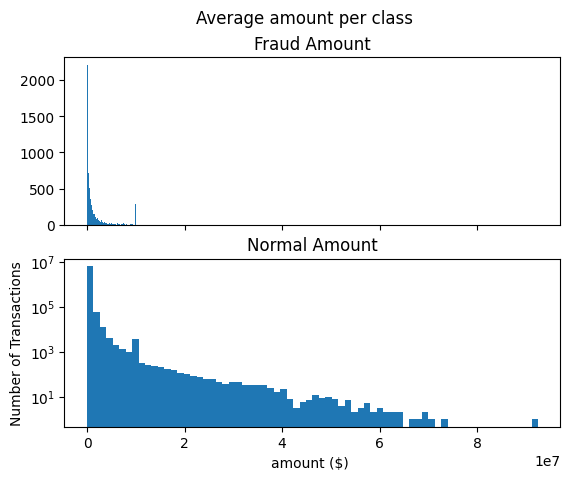

In [41]:
graph, (plot1, plot2) = plt.subplots(2,1,sharex = True) #sharex used to avoid overlapping of titles
graph.suptitle("Average amount per class")
bins = 70

plot1.hist(fraud_people['amount'], bins = bins)
plot1.set_title('Fraud Amount')

plot2.hist(normal_people['amount'], bins = bins)
plot2.set_title('Normal Amount')

plt.xlabel('amount ($) ')
plt.ylabel('Number of Transactions')
plt.yscale('log')
plt.show();

/tmp/ipython-input-3934111397.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_corr['type'].replace(['CASH_IN','CASH_OUT','DEBIT','PAYMENT','TRANSFER'],['1','2','3','4','5',], inplace=True)


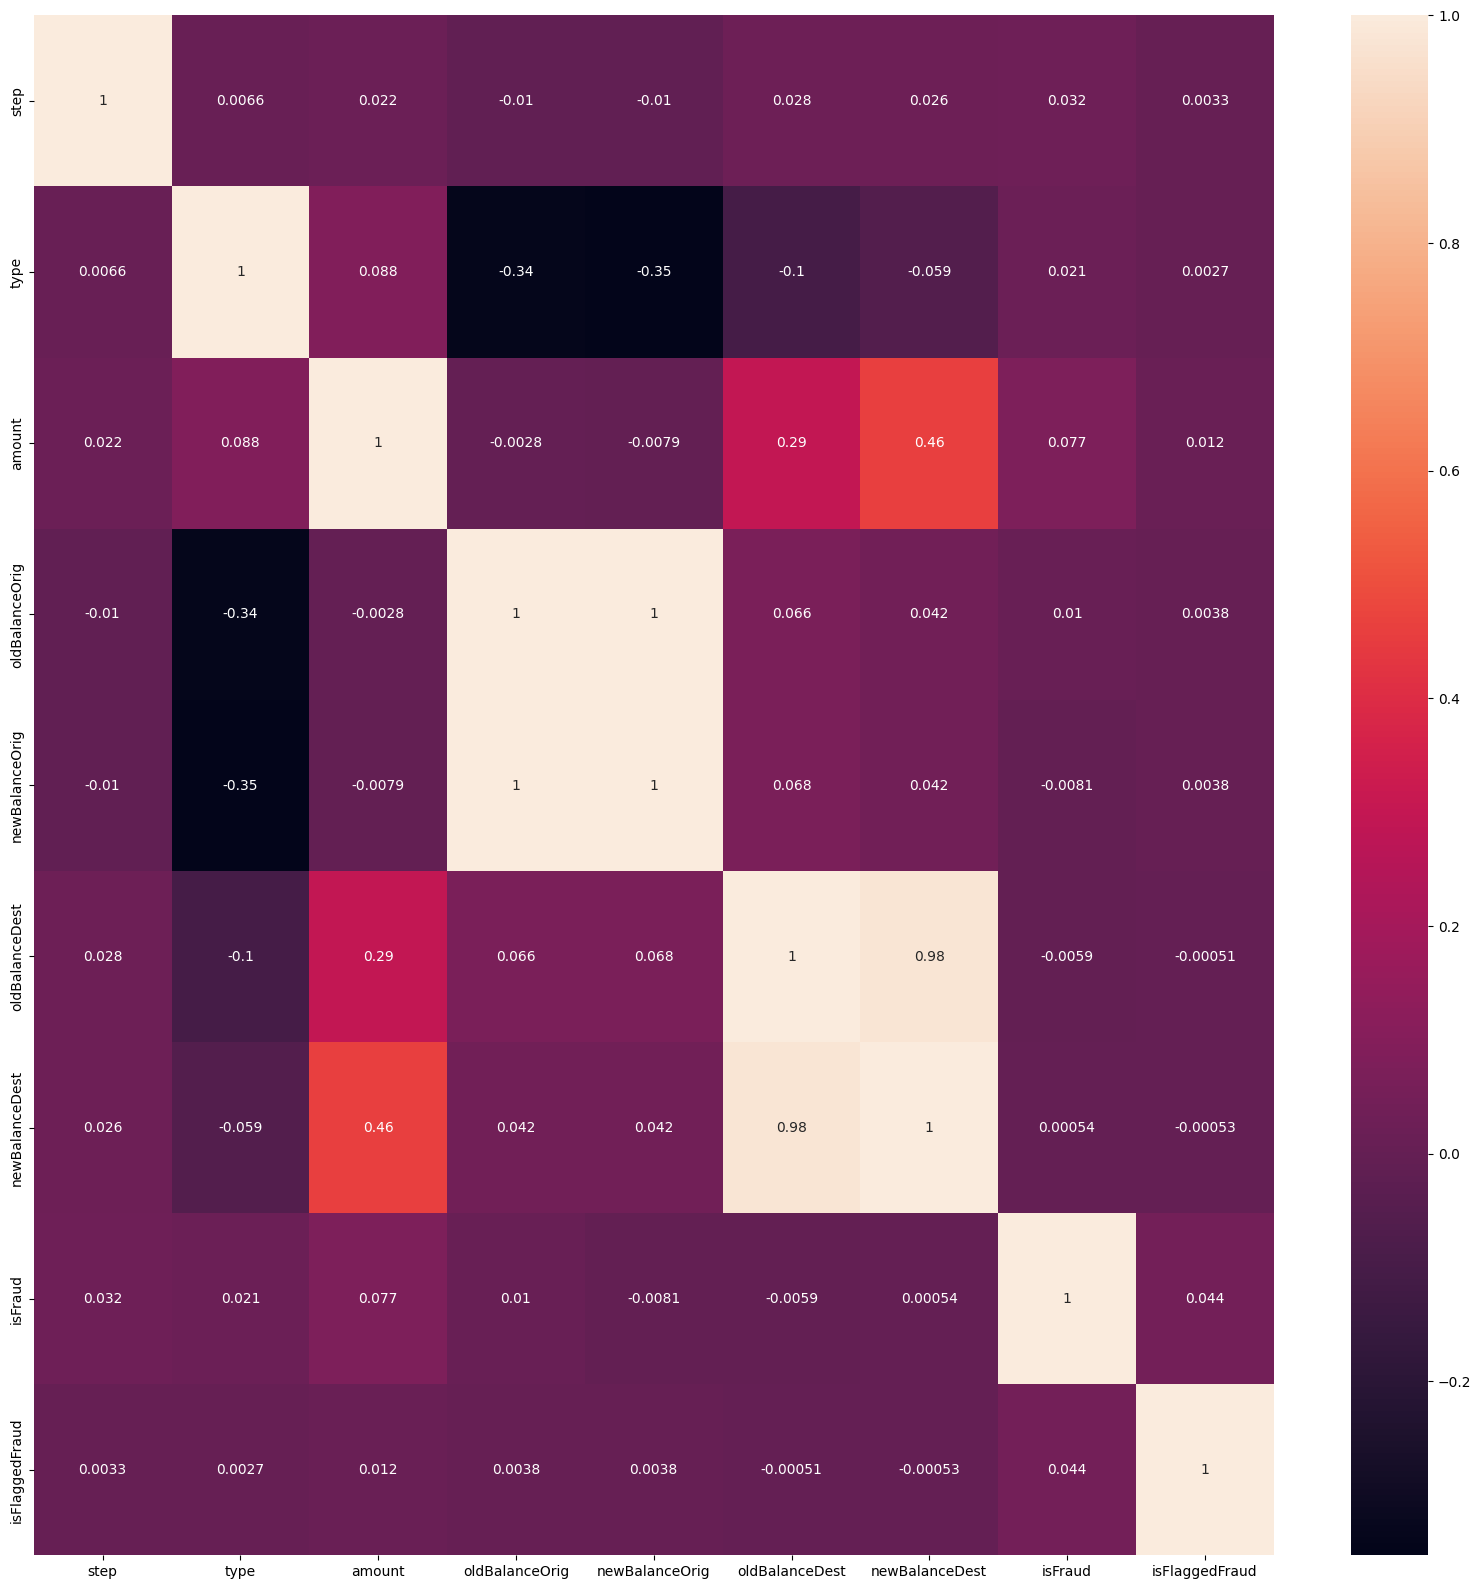

In [43]:
# Create a copy of df for correlation analysis to avoid modifying the original df prematurely
df_corr = df.copy()

# Encode the 'type' column, as done later for 'x'
df_corr['type'] = df_corr['type'].replace(['CASH_IN','CASH_OUT','DEBIT','PAYMENT','TRANSFER'],['1','2','3','4','5',])
# Convert the 'type' column to numeric after replacement
df_corr['type'] = pd.to_numeric(df_corr['type'])

# Drop non-numeric columns that cannot be used for correlation calculation
df_corr.drop(['nameOrig', 'nameDest'], axis=1, inplace=True)

plt.figure(figsize =(20,20))
g=sns.heatmap(df_corr.corr(),annot=True) #annot used to add text
plt.show()

In [44]:
columns = df.columns.tolist()
# Making our independent Features
columns = [var for var in columns if var not in ["isFraud"]]
# Making our Dependent Variable
target = "isFraud"
x = df[columns]
y = df[target]

In [45]:
x['type'].replace(['CASH_IN','CASH_OUT','DEBIT','PAYMENT','TRANSFER'],['1','2','3','4','5',], inplace=True)

/tmp/ipython-input-1353995510.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  x['type'].replace(['CASH_IN','CASH_OUT','DEBIT','PAYMENT','TRANSFER'],['1','2','3','4','5',], inplace=True)
/tmp/ipython-input-1353995510.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['type'].replace(['CASH_IN','CASH_OUT','DEBIT','PAYMENT','TRANSFER'],['1

In [46]:
x.drop(['nameOrig','nameDest','isFlaggedFraud'],axis=1, inplace=True)
x.head()

/tmp/ipython-input-3751962154.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x.drop(['nameOrig','nameDest','isFlaggedFraud'],axis=1, inplace=True)


,step,type,amount,oldBalanceOrig,newBalanceOrig,oldBalanceDest,newBalanceDest
0,1,4,9839.64,170136.0,160296.36,0.0,0.0
1,1,4,1864.28,21249.0,19384.72,0.0,0.0
2,1,5,181.00,181.0,0.00,0.0,0.0
3,1,2,181.00,181.0,0.00,21182.0,0.0
4,1,4,11668.14,41554.0,29885.86,0.0,0.0


In [47]:
y.head()

,isFraud
0,0
1,0
2,1
3,1
4,0


In [48]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.30, random_state = 42)

In [49]:
iso_forest = IsolationForest(n_estimators =100, max_samples = len(x_train), random_state=0, verbose=0)

In [ ]:
iso_forest.fit(x_train,y_train)

In [ ]:
ypred = iso_forest.predict(x_test)

In [ ]:
ypred[ypred == 1] = 0
ypred[ypred == -1] = 1

In [ ]:
print(accuracy_score(y_test,ypred))

In [ ]:
print(classification_report(y_test,ypred))

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
confusion_matrix(y_test, ypred)

In [ ]:
n_erorrs = (ypred != y_test).sum()
print("Isolation Forest have {} erorrs.".format(n_erorrs))